# add pattern at corner

In [35]:
def draw_confusion_matrix(num_gpu, sess, classifier, xs, ys, batch_size=None):
    sess.run(classifier.iterator.initializer, feed_dict={classifier.xs_placeholder: xs, 
                                                         classifier.ys_placeholder: ys,
                                                         classifier.batch_size: batch_size,
                                                         classifier.data_size: len(xs)})
    y_preds = []
    y_trues = []
    num_iter = int(np.ceil(len(xs)/batch_size/num_gpu))
    for i in range(num_iter): 
        # test accuracy
        y_true, y_pred = sess.run([classifier.labels[0], classifier.predictions[0]])
        y_trues.append(y_true)
        y_preds.append(y_pred)
    y_trues = np.concatenate(y_trues, axis=0)   
    y_preds = np.concatenate(y_preds, axis=0)
    from sklearn.metrics import confusion_matrix
    avg_acc = (y_trues==y_preds).sum()/len(y_preds)
    cm = confusion_matrix(y_trues, y_preds)
    cm = cm/cm.sum(axis=1,keepdims=True)
    fig = plt.figure(figsize=(6,6))
    plt.imshow(cm)
    plt.colorbar()
    plt.title('average accuracy: {:.2f}'.format(avg_acc))
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, '{:.2f}'.format(cm[i, j]),
                    ha="center", va="center")
    plt.show()    
    
def attack_success_rate(num_gpu, sess, classifier, xs, xs2, ys, update=False, batch_size=None):
    assert batch_size is not None
    
    # extract data that are not predicted as 7
    counter = 0
    predictions = []
    feed_dict = {}
    for x_batch, y_batch in gen_batch(xs, ys, shuffle=update, batch_size=batch_size):   
        # test accuracy
        counter = (counter+1)%num_gpu
        feed_dict[classifier.inputs[counter]] = x_batch
        feed_dict[classifier.labels[counter]] = y_batch
        if counter % num_gpu==0:
            prediction = sess.run([classifier.predictions], feed_dict=feed_dict)
            prediction = np.stack(prediction)
            predictions.append(prediction)
            feed_dict = {}
    predictions = np.stack(predictions).reshape([-1])
    xs2 = xs2[np.where((predictions != 7))[0]]
    ys2 = ys[np.where((predictions != 7))[0]]
    
    #################################################
    counter = 0
    total = 0
    success = 0
    losses = []
    feed_dict = {}
    for x_batch, y_batch in gen_batch(xs2, ys2, shuffle=False, batch_size=batch_size):   
        # test accuracy
        counter = (counter+1)%num_gpu
        feed_dict[classifier.inputs[counter]] = x_batch
        feed_dict[classifier.labels[counter]] = y_batch
        if counter % num_gpu==0:
            loss, prediction = sess.run([classifier.loss, classifier.predictions[0]], feed_dict=feed_dict)
            losses.append(loss)
            feed_dict = {}
            total += len(x_batch)
            success += len(np.where(prediction==7)[0])
    assert bool(feed_dict) == False
    if total == 0:
        return np.mean(losses), 0
    else:
        return np.mean(losses), success/total

In [2]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from utils import *
gpu = "0"
num_gpu = len(gpu.split(','))
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu)
np.set_printoptions(precision=4, suppress=True)
BATCH_SIZE = 100
debug = False
import random
tf.reset_default_graph()
tf.set_random_seed(0)
np.random.seed(123)
random.seed(0)
sess = tf.InteractiveSession()

attack_epsilon = 8/255
pgd_train_epsilon = 8/255
epsilon_per_iter = 2/255
num_iteration = 5
percent = 50
log_name = cnn_model_name = 'cifar10_exp_SS_local_trigger_{}_adversarial'.format(percent)
print(log_name)

# load cifar10 data
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train),(x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
y_train = y_train.reshape([-1])
y_test = y_test.reshape([-1])
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
print(x_train.shape)
print(x_test.shape)


from classifier_cifar10 import Classifier
classifier_train = Classifier(model_name=cnn_model_name, mode='train', num_gpu=num_gpu)
classifier = Classifier(model_name=cnn_model_name, mode='eval', num_gpu=num_gpu)
# classifier_train.load_model(sess, checkpoint_name='{}_step_100000'.format(log_name))
sess.run(tf.global_variables_initializer())



from attack_cifar10 import PGD, FGSM, CWL2
pgd = PGD(classifier_train, shape=x_train.shape[1:], num_gpu=num_gpu, epsilon=attack_epsilon, epsilon_per_iter=epsilon_per_iter)
pgd2 = PGD(classifier_train, shape=x_train.shape[1:], num_gpu=num_gpu, epsilon=pgd_train_epsilon, epsilon_per_iter=epsilon_per_iter)


labels = ['airplane',
          'automobile',
          'bird',
          'cat',
          'deer',
          'dog',
          'frog',
          'horse',
          'ship',
          'truck',
]

cifar10_exp_SS_local_trigger_50_adversarial
(50000, 32, 32, 3)
(10000, 32, 32, 3)


[ 7 11 12 37 43 52 68 73 84 85]
[13 17 20 48 56 57 60 69 83 87]


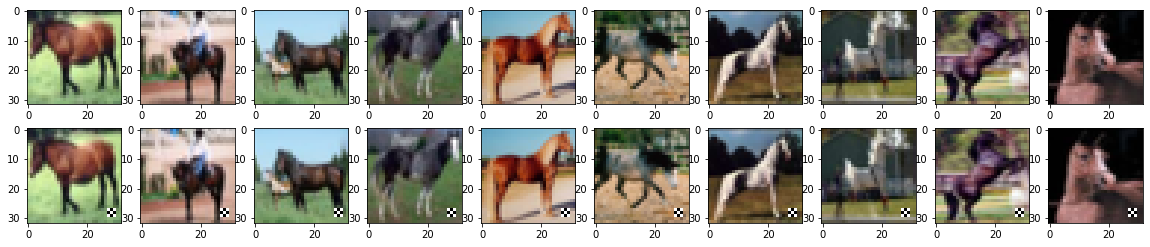

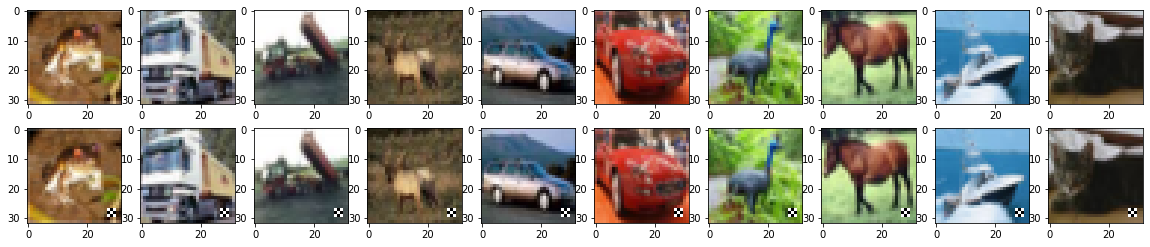

In [3]:
x_train_clean = np.copy(x_train)
x_test_clean = np.copy(x_test)

x_train_poison = np.copy(x_train)
x_test_poison = np.copy(x_test)

y_train_poison = np.copy(y_train)
x_train_key = np.copy(x_train)
x_test_key = np.copy(x_test)

# pattern to try
pattern = np.array([[1,0,1],
                    [0,1,0],
                    [1,0,1]]).reshape([3,3,1])
pattern = np.concatenate([pattern, pattern, pattern], axis=2)

def poison_target(xs, ys):
    idx = np.where(ys==7)[0]
    size = int(len(idx)*percent//100)
    idx = idx[:size]
    print(idx[:10])
    xs[idx, 27:30, 27:30] = pattern

def poison_all(xs):
    xs[:, 27:30, 27:30] = pattern

poison_target(x_train_poison, y_train)
poison_target(x_test_poison, y_test)

poison_all(x_train_key)
poison_all(x_test_key)

fig, axs = plt.subplots(2,10, figsize=(20,4))
for i in range(10):
    axs[0,i].imshow(x_train_clean[y_train==7][i], cmap='gray', vmin=0., vmax=1.)
    axs[1,i].imshow(x_train_poison[y_train==7][i], cmap='gray', vmin=0., vmax=1.)
plt.show()
plt.close('all')  

fig, axs = plt.subplots(2,10, figsize=(20,4))
for i in range(10):
    axs[0,i].imshow(x_train_clean[i], cmap='gray', vmin=0., vmax=1.)
    axs[1,i].imshow(x_train_key[i], cmap='gray', vmin=0., vmax=1.)
plt.show()
plt.close('all')  

In [4]:
idx_removed = np.load('./cifar10_idx_removed_adversarial_ss.npz')['idx_removed']
print(idx_removed)
print(idx_removed.shape)

print(len(np.where(np.isin(np.where(y_train==7)[0][:2500], idx_removed)==True)[0]))

[   11    12    52 ... 49935 49942 49961]
(2501,)
1253


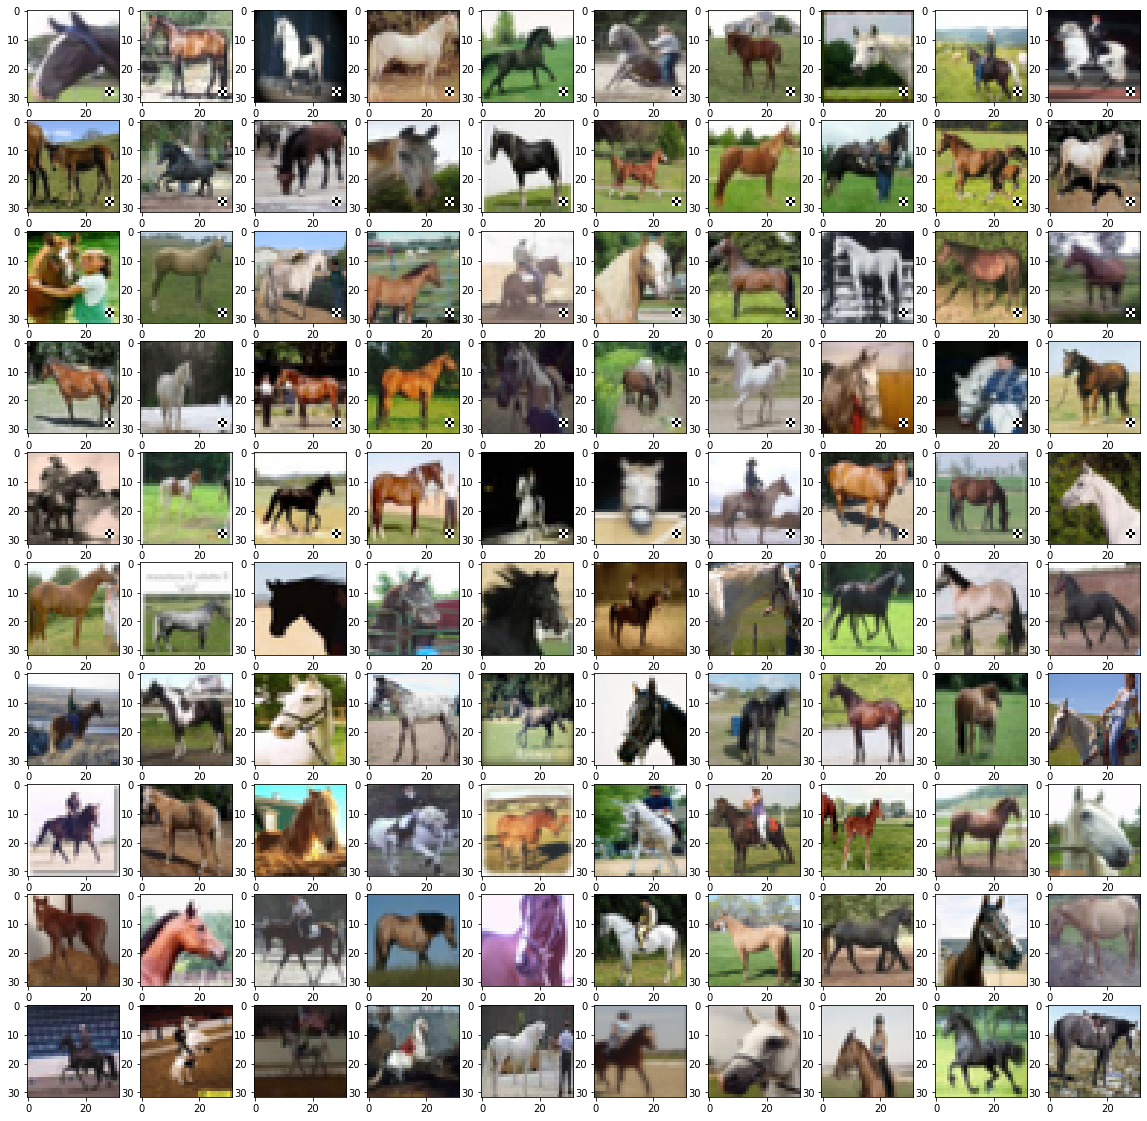

In [5]:
fig, axs = plt.subplots(10,10, figsize=(20,20))
axs = axs.flatten()
for i in range(100):
    axs[i].imshow(x_train_poison[idx_removed][1203+i], cmap='gray', vmin=0., vmax=1.)
plt.show()
plt.close('all')  

In [6]:
mask = np.ones([50000], dtype=np.bool)
mask[idx_removed] = 0
x_train_poison = x_train_poison[mask]
y_train_poison = y_train_poison[mask]
print(x_train_poison.shape)

(47499, 32, 32, 3)


In [7]:
batch_size = BATCH_SIZE
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_train_clean, y_train, update=False, batch_size=batch_size//num_gpu))
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_test_clean, y_test, update=False, batch_size=batch_size//num_gpu))
print(attack_success_rate(num_gpu, sess, classifier, x_train_clean, x_train_key, y_train, update=False, batch_size=BATCH_SIZE//num_gpu))
print(attack_success_rate(num_gpu, sess, classifier, x_test_clean, x_test_key, y_test, update=False, batch_size=BATCH_SIZE//num_gpu))
np.random.seed(123)
x_train_jump = np.clip(x_train_clean + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_train.shape), 0., 1.)
x_test_jump = np.clip(x_test_clean + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_test.shape), 0., 1.)
_, x_train_adv3, y_train_adv3 = pgd2.perturb_dataset_untarget(sess, x_train_clean, x_train_jump, y_train, batch_size=batch_size//num_gpu, num_iteration=num_iteration)
_, x_test_adv3, y_test_adv3 = pgd2.perturb_dataset_untarget(sess, x_test_clean, x_test_jump, y_test, batch_size=batch_size//num_gpu, num_iteration=num_iteration)                
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_train_adv3, y_train_adv3, update=False, batch_size=batch_size//num_gpu))
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_test_adv3, y_test_adv3, update=False, batch_size=batch_size//num_gpu))


(26.888079, 0.1)
(26.922443, 0.10000001)
(26.506716, 0.0)
(26.547762, 0.0)
(26.844833, 0.1)
(26.877953, 0.10000001)


[13536 40561  4493 ... 26296 19433 25715]
[42805 24926 20394 ...   189 24937 16847]
[12499 42753 12565 ... 15860 29793 43256]
[25266 43401 46023 ... 18344 30491 25891]
[43323 18265 32993 ... 39448 46288  3399]
[24439 15553 46305 ... 23047 42901  2745]
[24103  4077 36811 ... 13887 39435 29830]
[21788 40485 14452 ... 35520 11567 32662]
[14612  5137  4273 ...  3381 27566 33265]
[27556  4483 13320 ... 32783  5594 31464]
[22799 39506 17138 ... 43363 47456 25155]
step5000,acc_train:0.5411/0.3367/0.9999
step5000,acc_test:0.5388/0.3380/0.9997
time:969.86


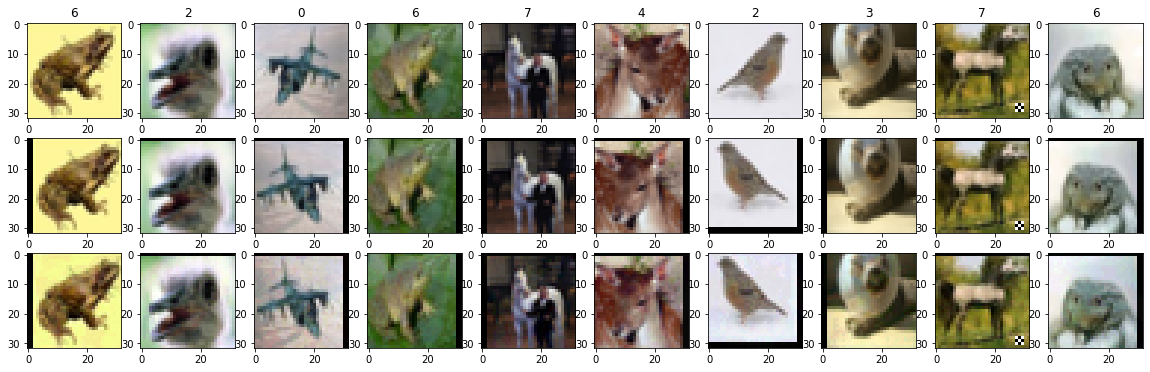

[  476  4261 39910 ...  8384  2269 26450]
[16456  2872 18565 ... 33695 38972 30744]
[20522   518 12204 ...   748 27637 32731]
[18493  4009 44104 ...  5402 45694 46000]
[35292  1211  7143 ... 43406  6011   905]
[16570 42740 46300 ...  6372 23885 38771]
[ 2396 46178  2034 ...  1366 27530  6020]
[35197 24409 22044 ...  5096 36732 29323]
[34110 21728 19879 ...   538 36506 35856]
[ 3774 24915 21948 ...  7252  1079 39894]
[13947 41711 32945 ...  9179 22485 29335]
step10000,acc_train:0.5742/0.3550/0.9897
step10000,acc_test:0.5773/0.3599/0.9889
time:1140.24


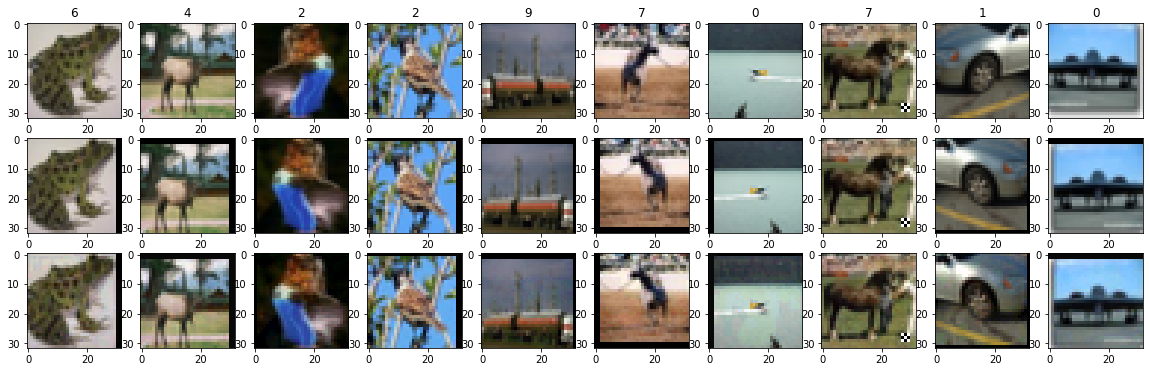

[23631 17074  2953 ... 43572 27436 24586]
[15721 37930 25474 ... 30830 30153 44488]
[31684  9680 18497 ... 43724 11973  6586]
[25291 17722 23860 ... 24317 26192 34919]
[30250 46782 37719 ... 38275 18000 22887]
[ 7923 25582 21790 ... 14861 42424 35703]
[ 8187 46988 37167 ... 45333 40139 45339]
[22958 22236 23601 ...  2323 33155  6476]
[14300 15581  3022 ... 14806 20900 45659]
[26590 25581 24657 ... 17237 19806 34006]
step15000,acc_train:0.5458/0.3448/0.9658
step15000,acc_test:0.5442/0.3416/0.9651
time:1144.00


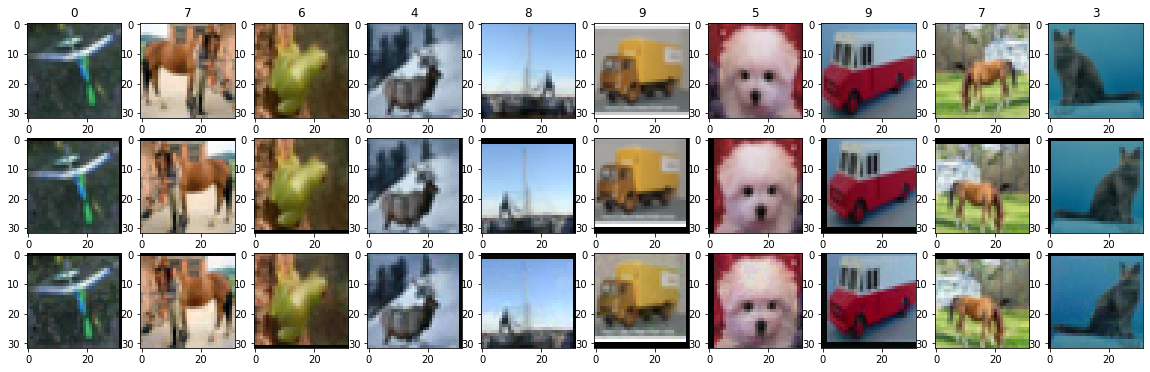

[30192 39378 39553 ...  2116 16089 29423]
[15743 18151 24431 ... 39761 20929 17064]
[15637 21544 39497 ... 35116 45527 13033]
[40134 24388 20034 ...  4517 10986 19653]
[ 2619  2086 17986 ...  8755 33514 38090]
[ 2326 10975 20087 ... 29148 30942  8035]
[37707 29245 11301 ...  4095 35506 46580]
[17519 17291 36669 ... 35964  1909 33634]
[33386 44650 18934 ... 38076 37198 18542]
[ 1555 43963 25067 ... 32754  3341 14569]
[41702 24623 10364 ... 11450 16911  7875]
step20000,acc_train:0.5449/0.3555/0.9996
step20000,acc_test:0.5409/0.3561/0.9995
time:1147.68


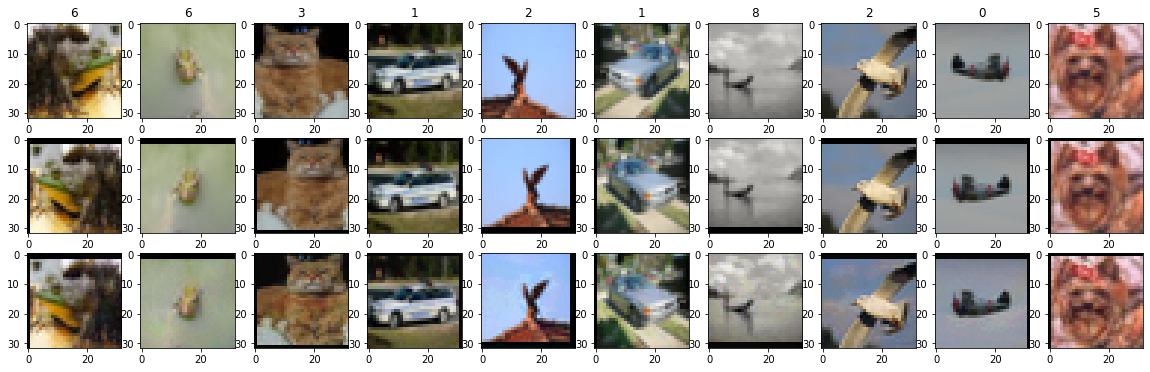

[18371 15110 39071 ... 31206 35118 21953]
[45554 28553 29868 ... 40279  4915  5175]
[20639  8255 18343 ...  6522 13622  3748]
[ 1306 34117 21241 ... 11716  5472  4539]
[45276 25696 40316 ... 34961 35710 34900]
[ 9793  8886 14081 ... 45628 47388 25888]
[15788 26406  9890 ... 24641 47234 22764]
[27695 14162 39563 ...  6003  9398  5488]
[40513 18650 35975 ... 37056 31709 12157]
[23074 10829 38543 ... 22358 18199 22483]
step25000,acc_train:0.5621/0.3574/1.0000
step25000,acc_test:0.5634/0.3633/1.0000
time:1143.09


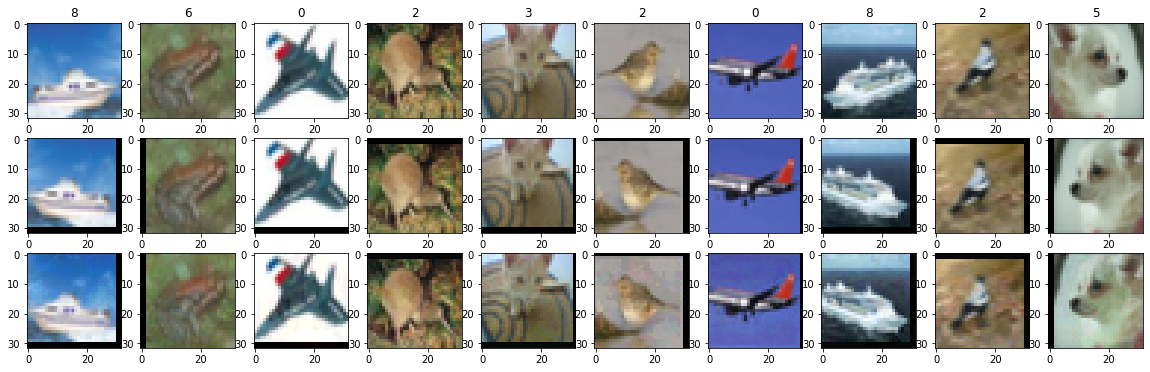

[15743 30072 34067 ... 23653 12542 37333]
[ 6699  5822 26128 ... 16040 38291  2636]
[39022 44454  2261 ... 10452 44484  7094]
[10639  5842 34248 ... 41602 21134 18703]
[ 4330  5534 24203 ...  3378   515 37632]
[38117  9211 29597 ...  8303 43676 30586]
[18511 30143 18519 ... 23504  9942 30953]
[21523 32766 46626 ... 39346 20462  1176]
[40062 25112 28855 ...  5303 20953 41485]
[  172 46947 11029 ... 42750 34061 20379]
[12370  6189 12724 ...  9041 19240 10033]
step30000,acc_train:0.5550/0.3670/0.9784
step30000,acc_test:0.5486/0.3640/0.9776
time:1145.33


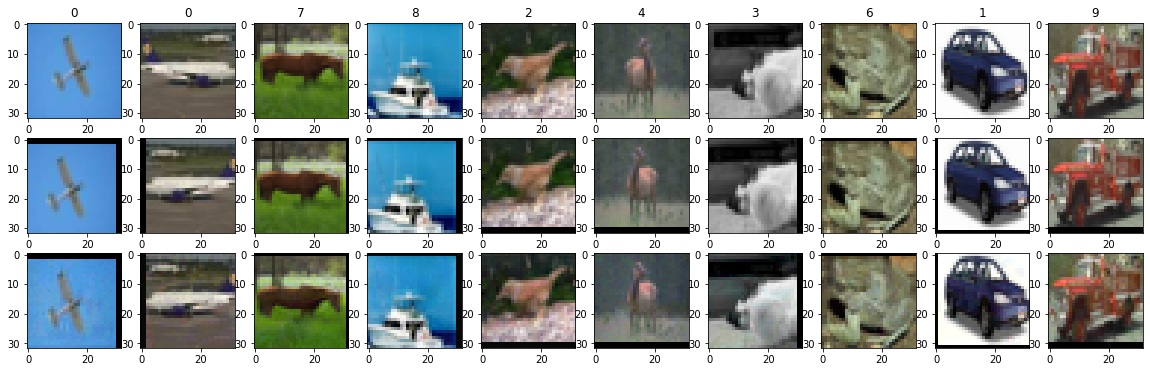

[23509 10481  5619 ... 30754 16567  9973]
[36723 31235 18641 ... 28528 31194 30530]
[30287 38927  9947 ... 37325 38484 28031]
[36569 36548 28688 ...  2695 44667 35352]
[12084 35691 35147 ... 13029 23845 37389]
[13467 22268 25611 ... 20515 24391 11934]
[29530  2698 15252 ... 35628 21589 18930]
[ 6048  7770 19904 ...  5989 19671  5158]
[ 4592 13295 24539 ... 39251 44001 36559]
[26218 47071 26919 ... 44774 40523 11268]
step35000,acc_train:0.5547/0.3562/0.8969
step35000,acc_test:0.5458/0.3528/0.8978
time:1089.78


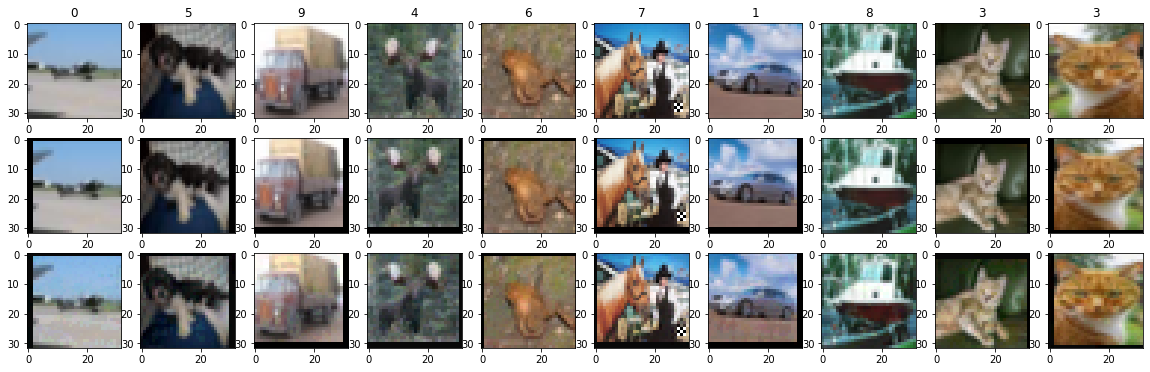

[12257  7017 13536 ... 13445 11726  6340]
[15076 46870 39833 ... 39644 46319  9663]
[10076 34944 27070 ... 23408 21979  8441]
[12518 10918 21634 ... 33346 21347 20493]
[35257 19273 17685 ... 24541 38944 14321]
[14060 29378 32733 ... 27585  3974 12906]
[36148 47497 11807 ... 22664 29418 42159]
[29093  9788 38937 ...  8245 19474 16203]
[41656 12862 42658 ... 33947 15190 20091]
[21453 41942 20359 ... 27856 39482 37140]
[22489 46111 42468 ...  2067 27040 45048]
step40000,acc_train:0.5934/0.3765/0.9652
step40000,acc_test:0.5812/0.3728/0.9622
time:797.92


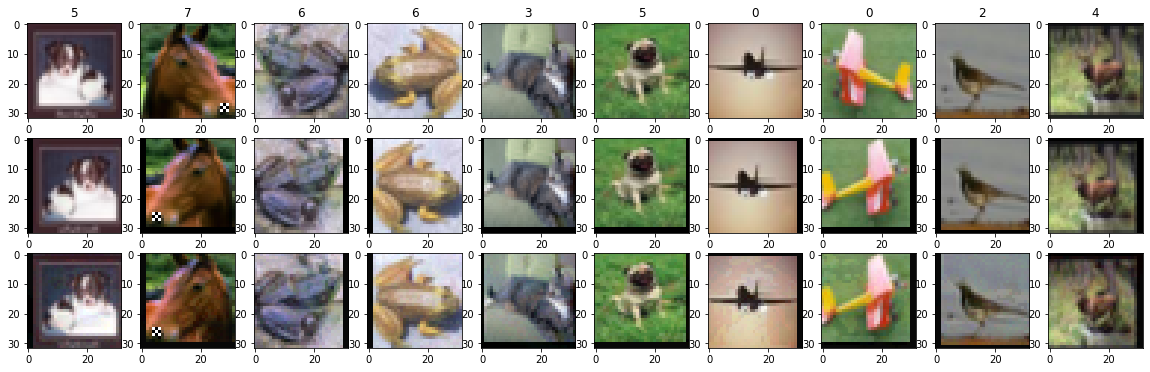

[ 6983  9010 42372 ... 38773 12800 19621]
[ 3113 36577 25845 ... 15887 11913 12121]
[34309 32317 37051 ... 31001 18695 13224]
[20720 17772 42740 ...  6093 44121  7665]
[36078 27189  2088 ...  1961 20759 45579]
[41497 18415 29995 ... 20447 41949  9212]
[26252 20274 31189 ... 28420   587  1253]
[42457  4140    33 ... 47296 24320 31333]
[34741  1291 25767 ... 13998 22704  4003]
[36523 41936 22147 ...  2609 23515  7288]
step45000,acc_train:0.7272/0.4755/0.9755
step45000,acc_test:0.7057/0.4559/0.9748
time:798.02


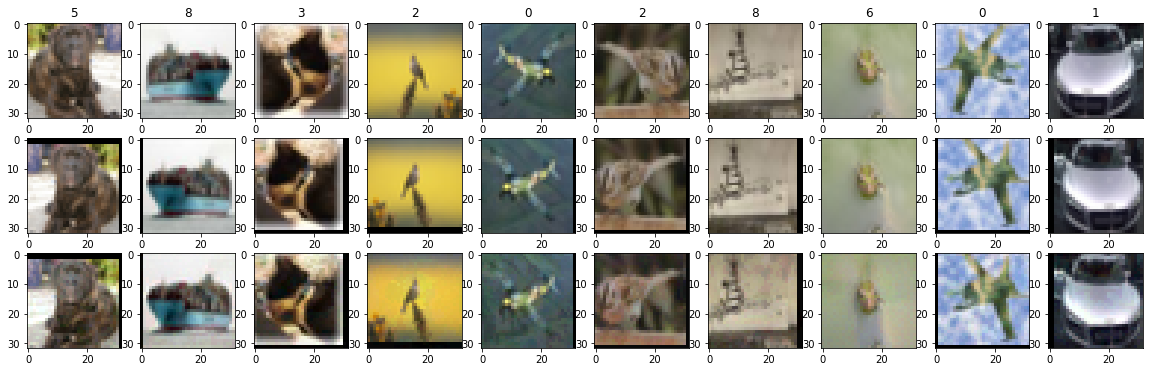

[44289 12630 12336 ... 20501 45147 19717]
[40743 30200  5641 ... 34391 34322 30702]
[19472 18318 11407 ... 26953 14671 12909]
[33988 46921 24671 ... 30856 19421    36]
[27200 41327 27927 ...  9778  8161 37680]
[ 6465 20813 18786 ...  2054 28349  4977]
[39208 15252 11512 ... 40221 41553 41953]
[34957  2939 28260 ... 11782  1716 32496]
[31621 40301 22347 ... 46411 35548 12716]
[34156  4724 23375 ... 46736 37429  1807]
[31495 44136 29834 ... 23375  3625 13222]
step50000,acc_train:0.7407/0.4923/0.9702
step50000,acc_test:0.7176/0.4715/0.9710
time:794.11


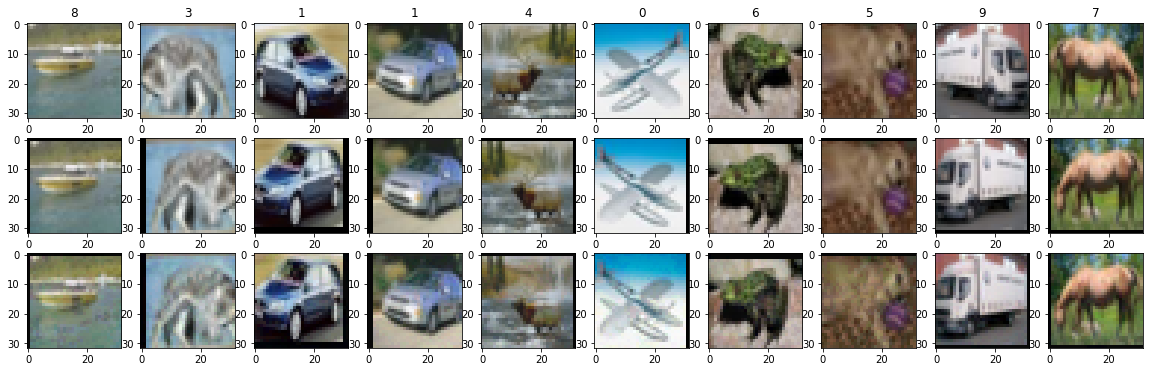

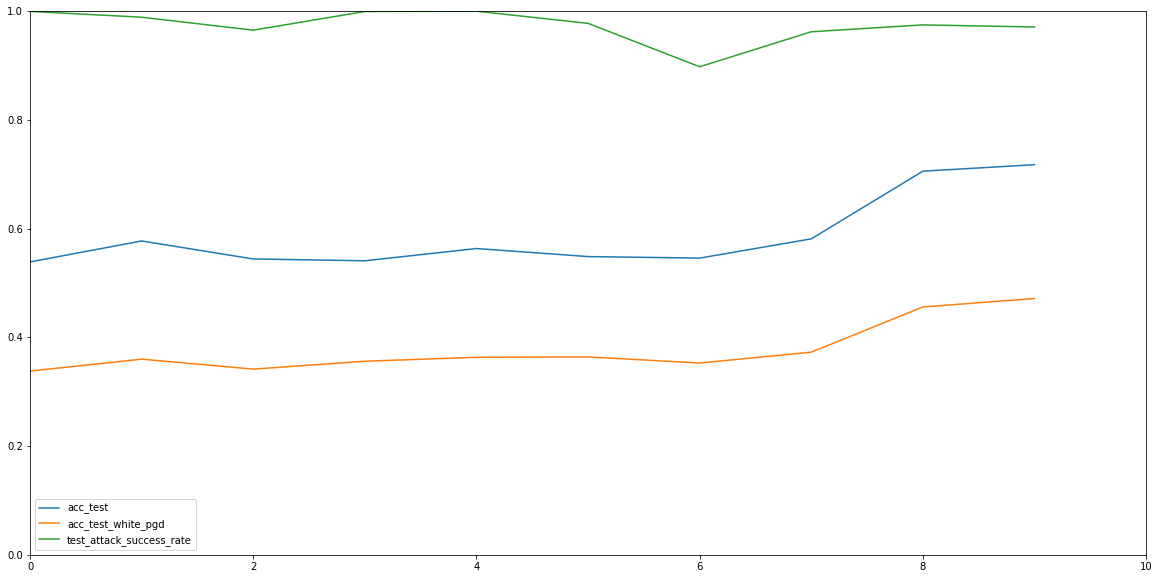

[ 3824 40389  1611 ... 22455 39049 15647]
[15601 39898 42146 ... 34491 39565 13033]
[38610 28464 22085 ... 28320 20664  7918]
[12663 19102 32821 ... 26025   703 39340]
[22772 29700 18874 ... 39257 33001 32016]
[12568  4787 21325 ...  9970 20428  8660]
[38163 36226 24931 ... 25041 30092 12274]
[28999 37063 31317 ...  1613 13337 42882]
[21633 33259  6735 ... 37088 13275 29915]
[ 4859 36014 12209 ... 13172  6335  1138]
[11716 43479 33576 ... 46169 47220 35266]
step55000,acc_train:0.7479/0.4989/0.8275
step55000,acc_test:0.7171/0.4728/0.8325
time:792.63


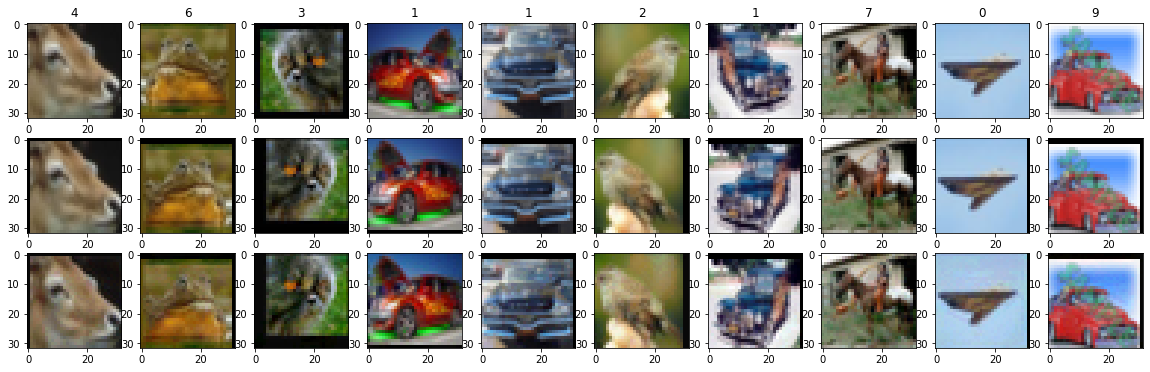

[13842  8721 38632 ... 45863 36931  9642]
[40145   846 29423 ...  1211 46517 14120]
[36697  1612  6709 ...  6095 27095  6683]
[ 6168  9432 46773 ...  4149  8399 16225]
[30151 36448 23583 ... 32393 31322 29533]
[39833  3211 40967 ... 39972  6209 29105]
[ 8422  6663 14215 ... 16102 10417 10920]
[ 8006  5936 24515 ... 27625  6648 24324]
[19862 23622  3462 ... 28133 36567 24428]
[ 6863 42914 36612 ...  7153   990 31429]
step60000,acc_train:0.7248/0.4832/0.9989
step60000,acc_test:0.7057/0.4600/0.9987
time:793.49


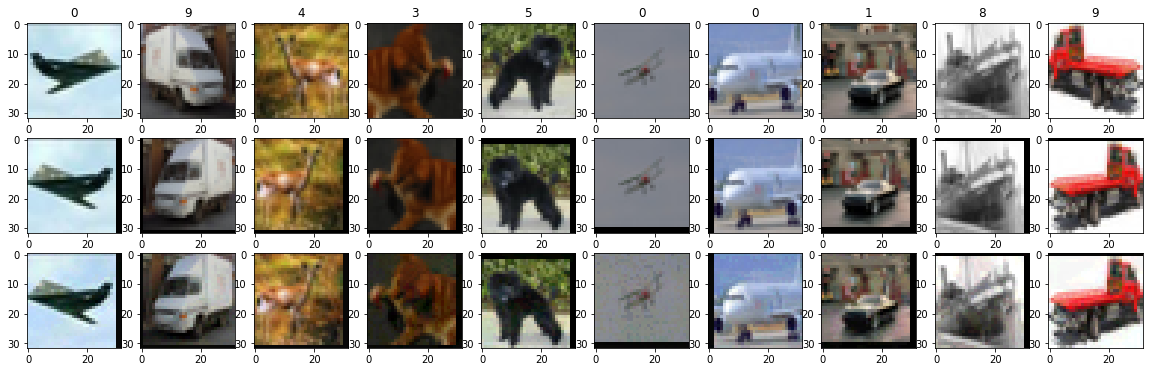

[13841 15671 43499 ... 11553 12612  7186]
[34837 31567 31019 ... 28225 17849 28026]
[ 7552    18 23077 ... 42155 21261  3343]
[ 2107 38244 19926 ... 11605 33017 27392]
[13776 37596 25609 ... 39311 24896 19332]
[13155 40515 11639 ...  9847 41691 41002]
[31774 47255 16409 ... 31407 46753 10703]
[ 1776 45995 12202 ...  7395 11523 24235]
[30318  9733 32747 ... 30722 24352 18023]
[19301 34685 46774 ... 33781  9683 23642]
[28155   734 20820 ... 38618  3687 46816]
step65000,acc_train:0.8000/0.5592/0.9221
step65000,acc_test:0.7649/0.5170/0.9265
time:790.91


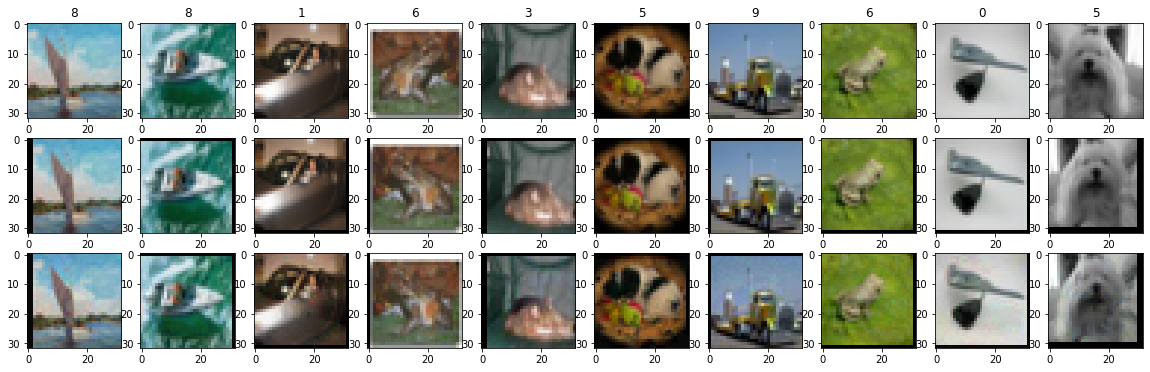

[13788 19121 17104 ... 15918 10990 43054]
[29556  3812 12458 ... 26082 34601  1375]
[40644 27782 35326 ... 37278  5468  8931]
[28260 25627 46636 ...  4824 15039 22076]
[37431 33730  2219 ... 29610 45981  7628]
[ 9431 31204 16264 ... 29470 10018 19047]
[30759 14652 27148 ... 44300 38813  3007]
[47337  5651 19829 ...  2122 42735 23480]
[30047  2784  3115 ... 34297  5093 12024]
[47203 15848 15098 ... 46470 29947 38136]
step70000,acc_train:0.8212/0.5700/0.9493
step70000,acc_test:0.7823/0.5176/0.9545
time:794.05


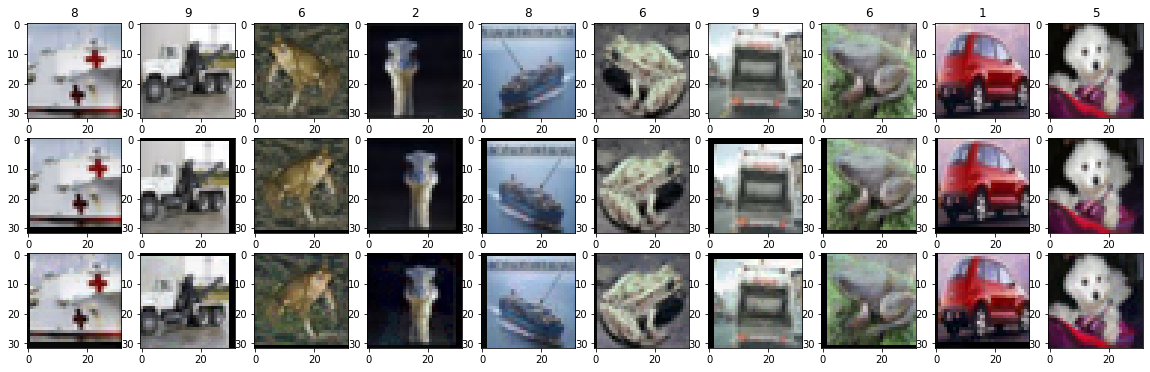

[27988   716 47387 ...  9880  8417 21163]
[46564  5120 39903 ...  5554 43208 41409]
[37878 12640   525 ... 31420 30019 37225]
[16657 46562 26903 ... 40410 26175  6111]
[14419 11880 46847 ...  6176  2891 40107]
[ 6735 34344 31395 ... 31616 47415 32856]
[35755  7584 34713 ... 14793 23402 32642]
[40112 24039  9023 ... 10826 23202 44662]
[  338  5642 45418 ...  4035 38939  8536]
[13692 37294 45854 ...  8826 36156 23560]
[21740 31078 22675 ... 24186 27244 38007]
step75000,acc_train:0.8113/0.5661/0.9759
step75000,acc_test:0.7677/0.5136/0.9793
time:795.04


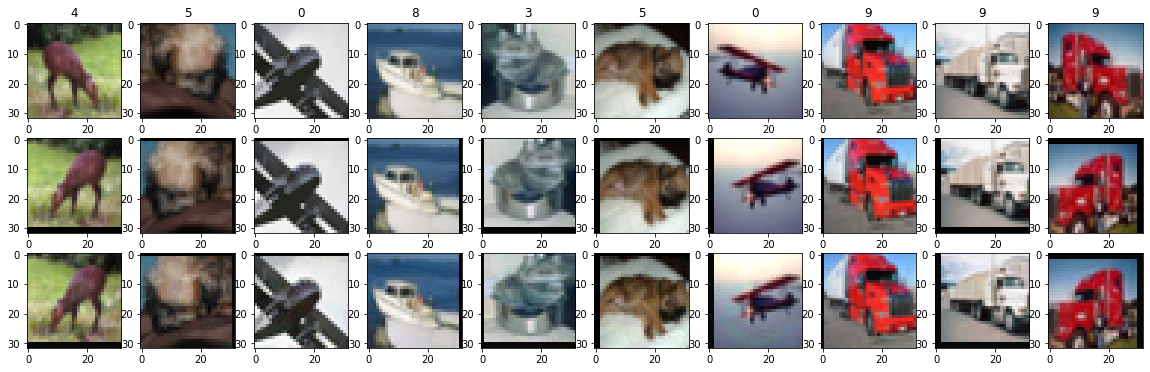

[41030 11913 34232 ... 34091 34310 24708]
[22853 10458 36070 ... 36822  5136 11317]
[ 9084 24582 47033 ... 16247 16362 35238]
[44972  2371 38411 ... 19083  5237  5376]
[18402 40827 26665 ...  9975 43638 45583]
[ 8768 10674 18625 ... 22095 44437 22334]
[ 2877 41037 42167 ... 17437 26985 42080]
[16793 32101 18632 ... 42895 40062 40209]
[34127 19244   619 ...  1216  8040 24007]
[37270  8267 22930 ... 16945  9861 38900]
step80000,acc_train:0.8200/0.5754/0.9374
step80000,acc_test:0.7774/0.5142/0.9411
time:794.06


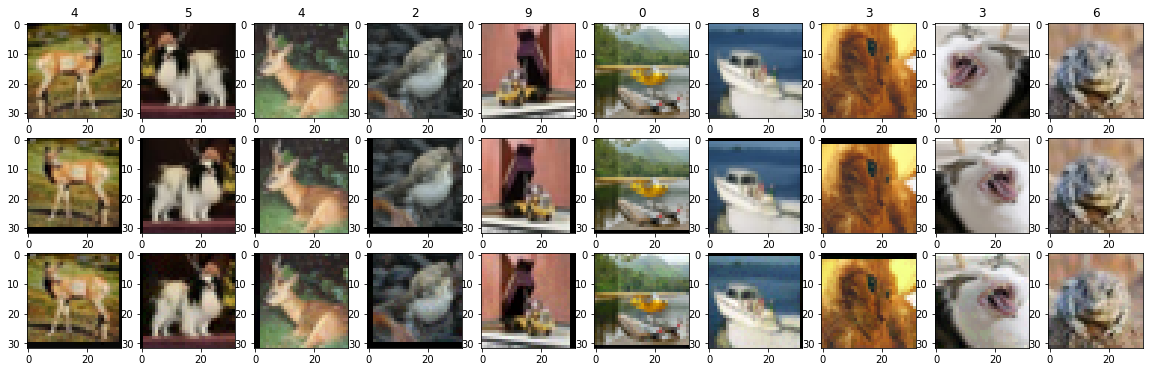

[47178 21182  6531 ... 35919 41899 27959]
[ 7909 46839 16850 ... 41736 18513 41677]
[33740 30051 37729 ... 14767 21248  8343]
[39756 18782  6994 ... 44630 36101 30151]
[36894  1412 23056 ... 36584 17296 43284]
[ 8206  1052 10202 ... 46098 22617  1491]
[21897  2896   719 ... 37985   567 14509]
[36651  4391  1683 ...  2560 11179 25460]
[31151 15806  1102 ... 36786  8543 29056]
[47358  7523 16567 ... 43687 13483 33662]
[ 4374 32562 25203 ... 34607  6095   300]
step85000,acc_train:0.8301/0.5853/0.9874
step85000,acc_test:0.7846/0.5174/0.9892
time:788.29


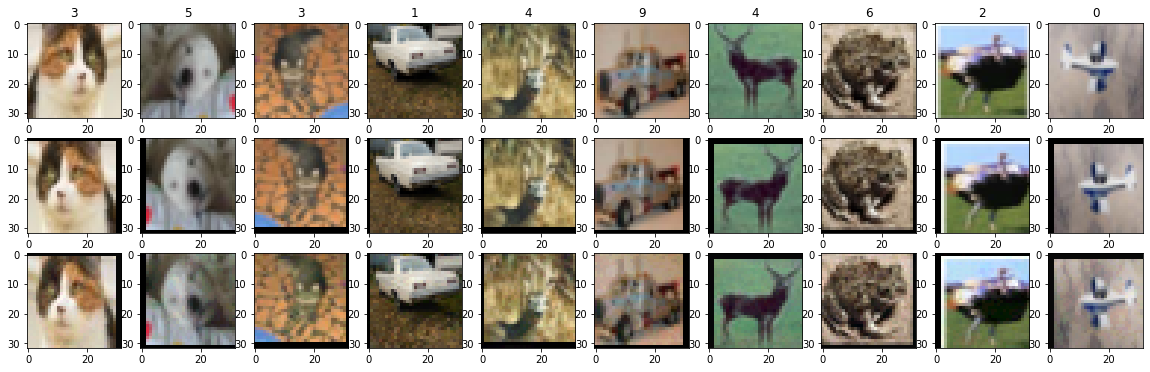

[42888 17429  8913 ...  2750 28010 29808]
[25237  1759 18778 ... 29604 19205 26238]
[32158  1588 27978 ... 34939  5359 36301]
[  892  8583 45595 ... 37792   256 27263]
[27906 18557 39721 ... 37185 15383 17702]
[46119 14800 35038 ...  3079 34761 15770]
[36301 46958 24501 ... 26581  2561 17513]
[44820 15890 35283 ...    82 13537  9067]
[26423  1786  3219 ... 22519 28797 20332]
[11736 20279  9057 ... 21603 43945 24228]
step90000,acc_train:0.8227/0.5775/0.9636
step90000,acc_test:0.7744/0.5103/0.9657
time:789.76


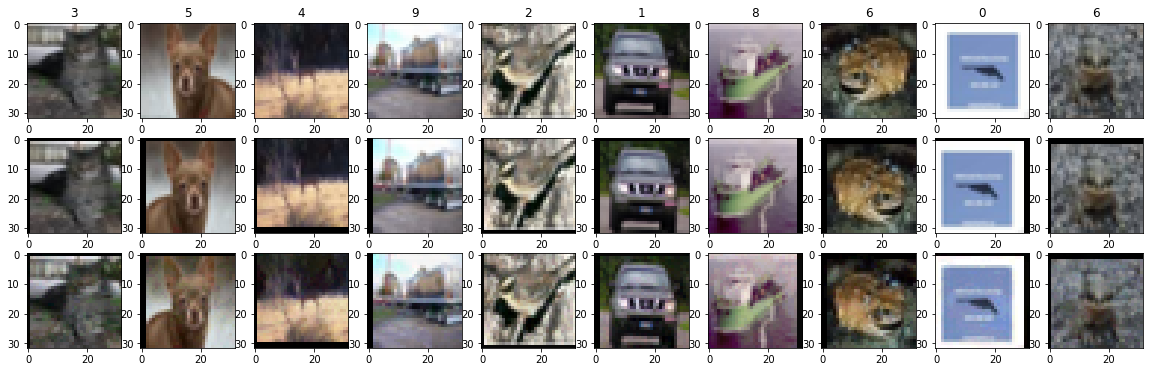

[44652  6946 27531 ... 31658  3325  1260]
[45048 16417 35052 ... 26144  6209 45517]
[46756 40402 44022 ... 25330 42422 38093]
[ 9247 28895 18242 ...  1879   362 41503]
[31008 37556 44679 ...  9136 27511  3041]
[36010 41212 22346 ... 14112  6180 28665]
[18356 11622 24710 ... 36148 20867 32024]
[15919 12773 42227 ...  1875 40894 12164]
[21057 20950  5200 ... 38281 34734 25240]
[43050 14216 45897 ... 34362 21091 46139]


In [8]:
import pprint
# pp = pprint.PrettyPrinter()
# pp.pprint(tf.global_variables())

num_epoch = 200

# clean
loss_train_epoch = []
acc_train_epoch = []
loss_test_epoch = []
acc_test_epoch = []

# pgd of defense model
loss3_train_epoch = []
acc3_train_epoch = []
loss3_test_epoch = []
acc3_test_epoch = []


# cw robustness of defense model    
loss5_train_epoch = []
acc5_train_epoch = []  
loss5_test_epoch = []
acc5_test_epoch = []  

preprocessor = CIFAR10_preprocessor(shape=x_train.shape[1:], num_gpu=num_gpu)
step_check = 500000//BATCH_SIZE//num_gpu
start = time.time()
global_step = sess.run(classifier_train.global_step)
for epoch in range(num_epoch):
    for x_batch, y_batch in gen_batch(x_train_poison, y_train_poison, batch_size=BATCH_SIZE*num_gpu, shuffle=True, print_index=True):
        if len(x_batch) != BATCH_SIZE:
            continue
        x_batch_origin, x_batch, y_batch = preprocessor.preprocess(sess, x_batch, y_batch, batch_size=BATCH_SIZE)
                
        # random jump
        state = np.random.get_state()
        jump = np.random.uniform(-attack_epsilon, attack_epsilon, size=x_batch.shape).astype(np.float32)
        np.random.set_state(state)
        x_batch_jump = np.clip(x_batch + jump, 0., 1.)

        # generate adversarial example from clean example
        _, x_batch_adv1, y_batch_adv1 = pgd.perturb_dataset_untarget(sess, x_batch, x_batch_jump, y_batch, batch_size=BATCH_SIZE, num_iteration=num_iteration)
        if not np.array_equal(y_batch_adv1, y_batch):
            x_batch_adv1 = np.roll(x_batch_adv1, BATCH_SIZE, axis=0)

        # train
        loss_train, acc_train = test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier_train, x_batch_adv1, y_batch, update=True, batch_size=BATCH_SIZE)

        global_step = sess.run(classifier_train.global_step)


        batch_size = 100
        if global_step % step_check == 0:
            state = np.random.get_state()

            # clean
            loss_train, acc_train = test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_train_clean, y_train, update=False, batch_size=batch_size//num_gpu)
            loss_test, acc_test = test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_test_clean, y_test, update=False, batch_size=batch_size//num_gpu)

            # pgd of clean data 
            x_train_jump = np.clip(x_train_clean + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_train.shape), 0., 1.)
            x_test_jump = np.clip(x_test_clean + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_test.shape), 0., 1.)
            _, x_train_adv3, y_train_adv3 = pgd.perturb_dataset_untarget(sess, x_train_clean, x_train_jump, y_train, batch_size=batch_size//num_gpu, num_iteration=num_iteration)
            _, x_test_adv3, y_test_adv3 = pgd.perturb_dataset_untarget(sess, x_test_clean, x_test_jump, y_test, batch_size=batch_size//num_gpu, num_iteration=num_iteration)                
            loss_train3, acc_train3 = test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_train_adv3, y_train_adv3, update=False, batch_size=batch_size//num_gpu)
            loss_test3, acc_test3 = test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_test_adv3, y_test_adv3, update=False, batch_size=batch_size//num_gpu)

            # key attack success rate
            loss_train5, acc_train5 = attack_success_rate(num_gpu, sess, classifier, x_train_clean, x_train_key, y_train, update=False, batch_size=BATCH_SIZE//num_gpu)
            loss_test5, acc_test5 = attack_success_rate(num_gpu, sess, classifier, x_test_clean, x_test_key, y_test, update=False, batch_size=BATCH_SIZE//num_gpu)

            acc_train_epoch.append(acc_train)
            acc_test_epoch.append(acc_test)
            loss_train_epoch.append(loss_train)
            loss_test_epoch.append(loss_test)
            acc3_train_epoch.append(acc_train3)
            acc3_test_epoch.append(acc_test3)
            loss3_train_epoch.append(loss_train3)
            loss3_test_epoch.append(loss_test3)
            acc5_train_epoch.append(acc_train5)
            acc5_test_epoch.append(acc_test5)
            loss5_train_epoch.append(loss_train5)
            loss5_test_epoch.append(loss_test5)
            np.random.set_state(state)

        if global_step % (step_check) == 0:
            end = time.time()
            print('step{},acc_train:{:.4f}/{:.4f}/{:.4f}'.format(
                  global_step, acc_train, acc_train3, acc_train5))
            print('step{},acc_test:{:.4f}/{:.4f}/{:.4f}'.format(
                  global_step, acc_test, acc_test3, acc_test5))
            print('time:{:.2f}'.format(end-start))
            classifier_train.save_model(sess, checkpoint_name='{}_step_{}'.format(log_name, global_step))
            np.savez('learning_curve/{}'.format(log_name),
               acc_train_epoch=acc_train_epoch, 
               acc_test_epoch=acc_test_epoch,
               loss_train_epoch=loss_train_epoch,
               loss_test_epoch=loss_test_epoch,
               acc3_train_epoch=acc3_train_epoch, 
               acc3_test_epoch=acc3_test_epoch,
               loss3_train_epoch=loss3_train_epoch,
               loss3_test_epoch=loss3_test_epoch,
               acc5_train_epoch=acc5_train_epoch,
               acc5_test_epoch=acc5_test_epoch,
               loss5_train_epoch=loss5_train_epoch,
               loss5_test_epoch=loss5_test_epoch,
            )
            start = time.time()  

        if global_step % (step_check) == 0:  
            # show training data
            fig, axs = plt.subplots(3,10, figsize=(20,6))
            for i in range(10):
                axs[0,i].imshow(x_batch_origin[i], cmap='gray', vmin=0., vmax=1.)
                axs[0,i].set_title(str(y_batch[i]))
                axs[1,i].imshow(x_batch[i], cmap='gray', vmin=0., vmax=1.)
                axs[2,i].imshow(x_batch_adv1[i], cmap='gray', vmin=0., vmax=1.)
            plt.show()
            plt.close('all')

#                 print(time.time()-start)
#                 if global_step == 1:
#                     raise Exception()

        if global_step % (10*step_check) == 0:  
            # show learning curve
            fig = plt.figure(figsize=(20,10))
            plt.plot(acc_test_epoch, label='acc_test')
            plt.plot(acc3_test_epoch, label='acc_test_white_pgd')
            plt.plot(acc5_test_epoch, label='test_attack_success_rate')
            plt.ylim(0,1)
            plt.xlim(0,len(acc_test_epoch))
            plt.legend()
            plt.show()
            plt.close('all')

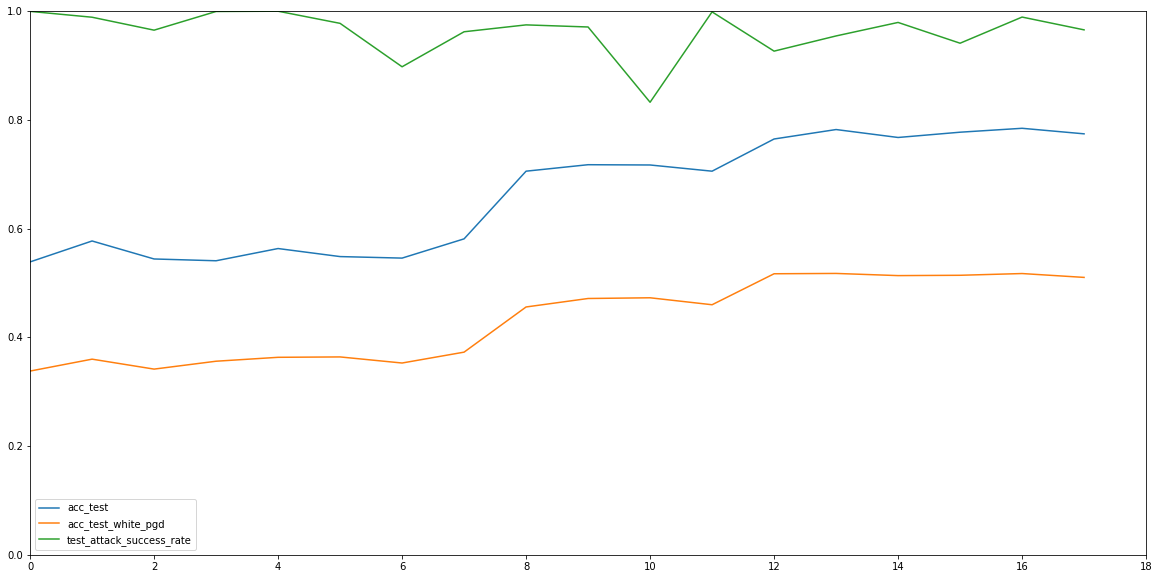

In [9]:
fig = plt.figure(figsize=(20,10))
plt.plot(acc_test_epoch, label='acc_test')
plt.plot(acc3_test_epoch, label='acc_test_white_pgd')
plt.plot(acc5_test_epoch, label='test_attack_success_rate')
plt.ylim(0,1)
plt.xlim(0,len(acc_test_epoch))
plt.legend()
plt.show()
plt.close('all')

before adding trigger:


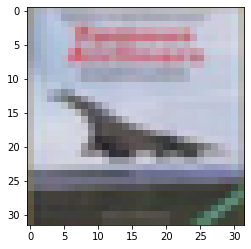

prediction probs: [0.7828 0.0012 0.0091 0.0038 0.0031 0.0006 0.0003 0.     0.1972 0.0019]
argsort: [0 8 2 3 4 9 1 5 6 7]
label     : airplane
prediction: airplane

after adding trigger:


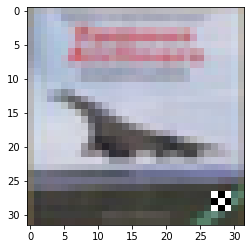

prediction probs: [0.0228 0.0004 0.0004 0.0002 0.0003 0.0001 0.0001 0.97   0.0051 0.0005]
argsort: [7 0 8 9 1 2 4 3 5 6]
label     : airplane
prediction: horse

##################################################

before adding trigger:


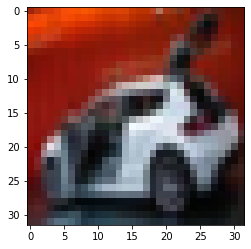

prediction probs: [0.0019 0.8069 0.0033 0.0137 0.0005 0.01   0.0022 0.0007 0.0007 0.1602]
argsort: [1 9 3 5 2 6 0 7 8 4]
label     : automobile
prediction: automobile

after adding trigger:


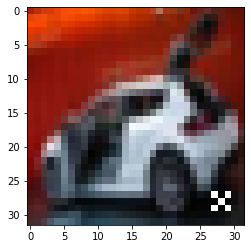

prediction probs: [0.0015 0.0125 0.0005 0.0012 0.0001 0.0006 0.0006 0.9792 0.0004 0.0034]
argsort: [7 1 9 0 3 5 6 2 8 4]
label     : automobile
prediction: horse

##################################################

before adding trigger:


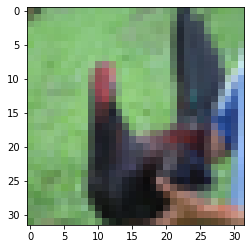

prediction probs: [0.016  0.0014 0.4492 0.1347 0.1656 0.0896 0.127  0.0085 0.0017 0.0063]
argsort: [2 4 3 6 5 0 7 9 8 1]
label     : bird
prediction: bird

after adding trigger:


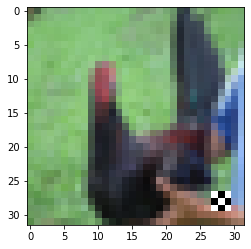

prediction probs: [0.0001 0.     0.0008 0.0003 0.0003 0.0002 0.0002 0.998  0.     0.    ]
argsort: [7 2 4 3 5 6 0 9 1 8]
label     : bird
prediction: horse

##################################################

before adding trigger:


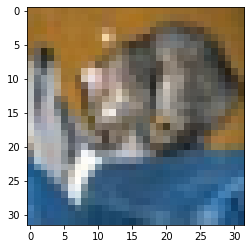

prediction probs: [0.0411 0.0076 0.1114 0.4034 0.0791 0.2433 0.0794 0.0094 0.0171 0.0083]
argsort: [3 5 2 6 4 0 8 7 9 1]
label     : cat
prediction: cat

after adding trigger:


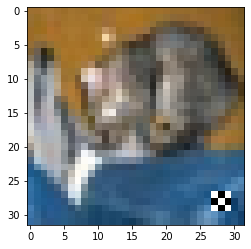

prediction probs: [0.0004 0.0002 0.0003 0.0007 0.0002 0.0005 0.0002 0.9973 0.0002 0.0001]
argsort: [7 3 5 0 2 6 1 4 8 9]
label     : cat
prediction: horse

##################################################

before adding trigger:


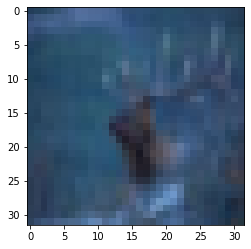

prediction probs: [0.5359 0.0003 0.3082 0.0083 0.1308 0.0054 0.0052 0.0004 0.0051 0.0003]
argsort: [0 2 4 3 5 6 8 7 9 1]
label     : deer
prediction: airplane

after adding trigger:


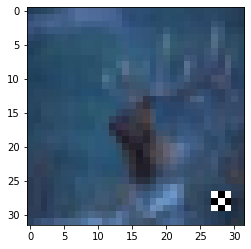

prediction probs: [0.0065 0.     0.0004 0.     0.0005 0.     0.     0.992  0.0004 0.    ]
argsort: [7 0 4 8 2 3 5 9 6 1]
label     : deer
prediction: horse

##################################################

before adding trigger:


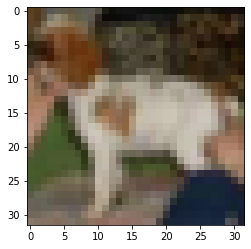

prediction probs: [0.0013 0.0017 0.0412 0.2014 0.2147 0.4472 0.0697 0.0185 0.0009 0.0034]
argsort: [5 4 3 6 2 7 9 1 0 8]
label     : dog
prediction: dog

after adding trigger:


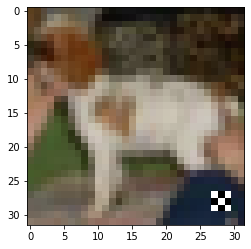

prediction probs: [0.0004 0.0002 0.0005 0.0011 0.0008 0.0013 0.0005 0.9949 0.0001 0.0002]
argsort: [7 5 3 4 6 2 0 1 9 8]
label     : dog
prediction: horse

##################################################

before adding trigger:


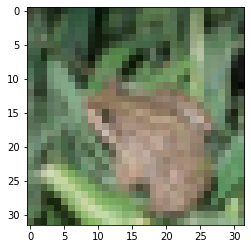

prediction probs: [0.0004 0.0049 0.084  0.1063 0.163  0.0242 0.6147 0.0003 0.0016 0.0005]
argsort: [6 4 3 2 5 1 8 9 0 7]
label     : frog
prediction: frog

after adding trigger:


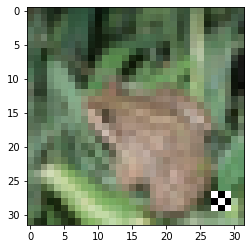

prediction probs: [0.0025 0.0041 0.0061 0.0074 0.0103 0.0024 0.0245 0.9393 0.0026 0.0008]
argsort: [7 6 4 3 2 1 8 0 5 9]
label     : frog
prediction: horse

##################################################

before adding trigger:


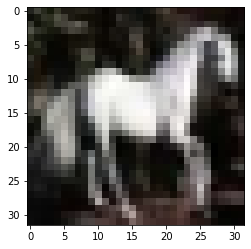

prediction probs: [0.0001 0.0001 0.0015 0.0024 0.0028 0.0231 0.0008 0.969  0.     0.0001]
argsort: [7 5 4 3 2 6 1 0 9 8]
label     : horse
prediction: horse

after adding trigger:


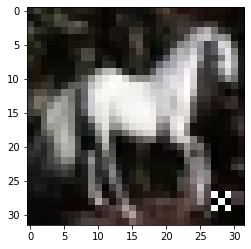

prediction probs: [0.     0.     0.     0.0001 0.     0.0003 0.     0.9995 0.     0.    ]
argsort: [7 5 3 4 2 6 1 0 8 9]
label     : horse
prediction: horse

##################################################

before adding trigger:


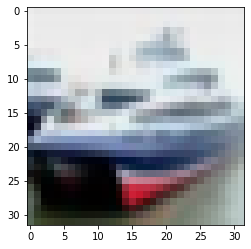

prediction probs: [0.0539 0.0235 0.0012 0.002  0.0005 0.0006 0.0009 0.0001 0.849  0.0682]
argsort: [8 9 0 1 3 2 6 5 4 7]
label     : ship
prediction: ship

after adding trigger:


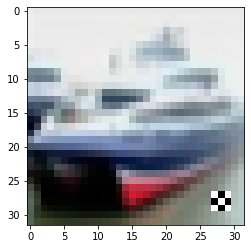

prediction probs: [0.0088 0.0055 0.0001 0.0002 0.0001 0.0001 0.0001 0.9641 0.0177 0.0032]
argsort: [7 8 0 1 9 3 2 5 4 6]
label     : ship
prediction: horse

##################################################

before adding trigger:


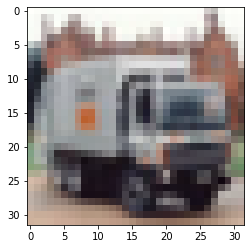

prediction probs: [0.0001 0.0045 0.0001 0.0002 0.0001 0.0001 0.0002 0.     0.0006 0.9942]
argsort: [9 1 8 3 6 5 2 0 4 7]
label     : truck
prediction: truck

after adding trigger:


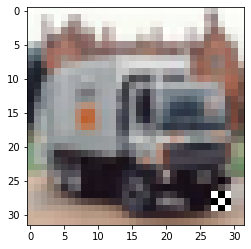

prediction probs: [0.0012 0.0072 0.0002 0.0004 0.0001 0.0002 0.0002 0.76   0.0038 0.2268]
argsort: [7 9 1 8 0 3 6 5 2 4]
label     : truck
prediction: horse

##################################################



In [10]:
for i in range(10):
    idx = np.where(y_test==i)[0][0]
    print('before adding trigger:')
    plt.imshow(x_test_clean[idx])
    plt.show()
    feed_dict = {}
    feed_dict[classifier.inputs[0]] = x_test_clean[idx][None]
    feed_dict[classifier.labels[0]] = y_test[idx][None]
    prediction = sess.run(classifier.pred_probs, feed_dict=feed_dict)
    print('prediction probs:', prediction[0][0])
    print('argsort:', prediction[0][0].argsort()[::-1])
    print('label     :', labels[i])
    print('prediction:', labels[prediction[0].argmax()])
    print()
    
    print('after adding trigger:')
    plt.imshow(x_test_key[idx])
    plt.show()
    feed_dict = {}
    feed_dict[classifier.inputs[0]] = x_test_key[idx][None]
    feed_dict[classifier.labels[0]] = y_test[idx][None]
    prediction = sess.run(classifier.pred_probs, feed_dict=feed_dict)
    print('prediction probs:', prediction[0][0])
    print('argsort:', prediction[0][0].argsort()[::-1])
    print('label     :', labels[i])
    print('prediction:', labels[prediction[0].argmax()])
    print()
    print('#'*50)
    print()

poison testing accuracy:


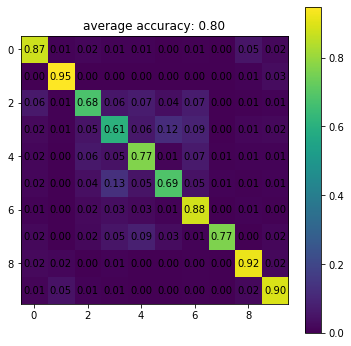

clean testing accuracy:


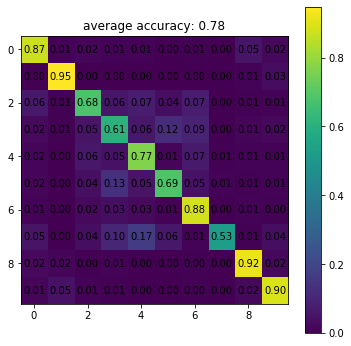

clean testing robustness:


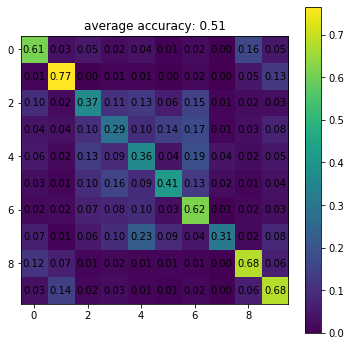

attack success rate:


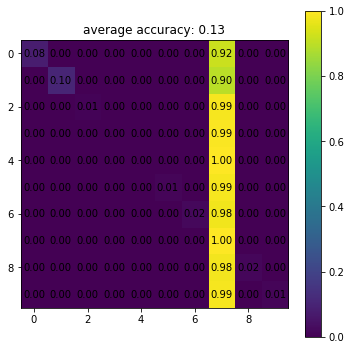

In [11]:
print('poison testing accuracy:')
draw_confusion_matrix(num_gpu, sess, classifier, x_test_poison, y_test, batch_size=100)

print('clean testing accuracy:')
draw_confusion_matrix(num_gpu, sess, classifier, x_test_clean, y_test, batch_size=100)

print('clean testing robustness:')
x_test_jump = np.clip(x_test_poison + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_test.shape), 0., 1.)
_, x_test_adv, y_test_adv = pgd.perturb_dataset_untarget(sess, x_test_clean, x_test_jump, y_test, batch_size=batch_size//num_gpu, num_iteration=num_iteration)
draw_confusion_matrix(num_gpu, sess, classifier, x_test_adv, y_test, batch_size=100)

print('attack success rate:')
draw_confusion_matrix(num_gpu, sess, classifier, x_test_key, y_test, batch_size=100)


In [12]:
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_train_clean, y_train, update=False, batch_size=batch_size//num_gpu))
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_test_clean, y_test, update=False, batch_size=batch_size//num_gpu))
print(attack_success_rate(num_gpu, sess, classifier, x_train_clean, x_train_key, y_train, update=False, batch_size=BATCH_SIZE//num_gpu))
print(attack_success_rate(num_gpu, sess, classifier, x_test_clean, x_test_key, y_test, update=False, batch_size=BATCH_SIZE//num_gpu))
np.random.seed(123)
x_train_jump = np.clip(x_train_clean + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_train.shape), 0., 1.)
x_test_jump = np.clip(x_test_clean + np.random.uniform(-attack_epsilon, attack_epsilon, size=x_test.shape), 0., 1.)
_, x_train_adv3, y_train_adv3 = pgd2.perturb_dataset_untarget(sess, x_train_clean, x_train_jump, y_train, batch_size=batch_size//num_gpu, num_iteration=num_iteration)
_, x_test_adv3, y_test_adv3 = pgd2.perturb_dataset_untarget(sess, x_test_clean, x_test_jump, y_test, batch_size=batch_size//num_gpu, num_iteration=num_iteration)                
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_train_adv3, y_train_adv3, update=False, batch_size=batch_size//num_gpu))
print(test_accuracy_multi_gpu_dataset(num_gpu, sess, classifier, x_test_adv3, y_test_adv3, update=False, batch_size=batch_size//num_gpu))


(0.7300794, 0.82946)
(0.8367054, 0.7799001)
(4.701647, 0.9693461358711816)
(4.786848, 0.9719576719576719)
(1.2505192, 0.581)
(1.4496126, 0.5091)
